In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import diff_gaussian_rasterization

In [2]:
device = torch.device("cuda")

In [3]:
def gen_orthographic_matrix(
    left: float, right: float, bottom: float, top: float, near: float, far: float
):
    """Generate orthographic projection matrix.

    Args:
        left (float): left plane
        right (float): right plane
        bottom (float): bottom plane
        top (float): top plane
        near (float): near plane
        far (float): far plane

    Returns:
        torch.Tensor: orthographic projection matrix
    """
    return torch.tensor(
        [
            [2 / (right - left), 0, 0, -(right + left) / (right - left)],
            [0, 2 / (top - bottom), 0, -(top + bottom) / (top - bottom)],
            [0, 0, -2 / (far - near), -(far + near) / (far - near)],
            [0, 0, 0, 1],
        ]
    )


# predicts a set of gaussians that accurately represent an input image
class GaussianPredictor(nn.Module):
    def __init__(self, n_gaussians=16):
        super().__init__()
        self.n_gaussians = n_gaussians
        # 64x64 -> 32x32
        self.conv1 = nn.Conv2d(1, 32, 3, stride=2, padding=1)
        self.conv1_bn = nn.BatchNorm2d(32)
        # 32x32 -> 16x16
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv2_bn = nn.BatchNorm2d(64)
        # 16x16 -> 8x8
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.conv3_bn = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 8 * 8, 1024)
        self.fc2 = nn.Linear(1024, n_gaussians*6) # [x, y, sx, sy, r, o] * n_gaussians

        FoVx = 90
        FoVy = 90

        raster_settings = diff_gaussian_rasterization.GaussianRasterizationSettings(
            image_height=64,
            image_width=64,
            tanfovx=math.tan(FoVx * 0.5),
            tanfovy=math.tan(FoVy * 0.5),
            bg=torch.zeros(4, dtype=torch.float32, device=device),
            scale_modifier=1.0,
            viewmatrix=torch.eye(4, dtype=torch.float32, device=device),
            projmatrix=gen_orthographic_matrix(-1, 1, -1, 1, -1, 1).to(device),
            sh_degree=1,
            campos=torch.tensor([0, 0, 0], dtype=torch.float32, device=device),
            prefiltered=False,
            debug=False,
        )

        self.rasterizer = diff_gaussian_rasterization.GaussianRasterizer(
            raster_settings=raster_settings
        )



    def render_images_batch(
        self,
        # [B, N, 2]
        means: torch.Tensor,
        # [B, N, 2]
        scales: torch.Tensor,
        # [B, N, 1]
        rotations: torch.Tensor,
        # [B, N, 1]
        opacities: torch.Tensor,
    ) -> torch.Tensor:
        B, N = means.shape[:2]
        assert N >= 0
        assert means.shape == (B, N, 2)
        assert scales.shape == (B, N, 2)
        assert rotations.shape == (B, N, 1)
        assert opacities.shape == (B, N, 1)

        means3D = torch.cat(
            [means, torch.ones(B, N, 1, dtype=torch.float32, device=device)], dim=-1
        )
        means2D = torch.zeros(B, N, 3, dtype=torch.float32, device=device)
        scales = torch.cat(
            [scales, torch.zeros(B, N, 1, dtype=torch.float32, device=device)], dim=-1
        )
        quaternions = torch.cat(
            [
                torch.cos(rotations / 2),
                torch.zeros(B, N, 1, dtype=torch.float32, device=device),
                torch.zeros(B, N, 1, dtype=torch.float32, device=device),
                torch.sin(rotations / 2),
            ],
            dim=-1,
        )
        colors_precomp = torch.ones(B, N, 3, dtype=torch.float32, device=device)

        imlist = []
        for b in range(B):
            rendered_image, _ = self.rasterizer(
                means3D=means3D[b],
                means2D=means2D[b],
                colors_precomp=colors_precomp[b],
                opacities=opacities[b],
                scales=scales[b],
                rotations=quaternions[b],
            )
            image_bw = rendered_image.mean(dim=0, keepdim=True)
            imlist.append(image_bw)

        return torch.stack(imlist)

    def predict_gaussians(self, x):
        # x: B x 3 x 64 x 64
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(-1, self.n_gaussians, 6)
        return x
    
    def forward(self, x):
        gaussian_preds = self.predict_gaussians(x)

        means_batched = torch.tanh(gaussian_preds[:, :, :2])
        scales_batched = torch.sigmoid(gaussian_preds[:, :, 2:4])
        rotations_batched = torch.sigmoid(gaussian_preds[:, :, 4:5])*math.pi*0.5
        opacities_batched = torch.sigmoid(gaussian_preds[:, :, 5:])
        rasterized_pred = self.render_images_batch(means_batched, scales_batched, rotations_batched, opacities_batched)

        return rasterized_pred

In [4]:
def train_gaussian_predictor(
    model: GaussianPredictor,
    optim: torch.optim.Optimizer,
    images: torch.Tensor,
) -> float:
    model.train()

    images = images.to(device)

    # predict gaussians
    rasterized_pred = model(images)

    # compute loss
    loss = F.mse_loss(rasterized_pred, images)

    # step loss
    optim.zero_grad()
    loss.backward()
    optim.step()

    return loss.item()

In [5]:
# download mnist dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = datasets.MNIST('data', download=True, train=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# create model
model = GaussianPredictor().to(device)
optim = torch.optim.Adam(model.parameters(), lr=2e-5)

losses = []

In [6]:
# train model
for epoch in range(3):
    print(f"Epoch {epoch}")
    for i, (images, labels) in enumerate(tqdm(trainloader)):
        loss = train_gaussian_predictor(model, optim, images)
        losses.append(loss)
    print(f"Loss: {loss}")

Epoch 0


100%|██████████| 938/938 [01:03<00:00, 14.70it/s]


Loss: 0.8542910218238831
Epoch 1


100%|██████████| 938/938 [01:04<00:00, 14.51it/s]


Loss: 0.8302984237670898
Epoch 2


100%|██████████| 938/938 [00:59<00:00, 15.81it/s]

Loss: 0.8090927004814148


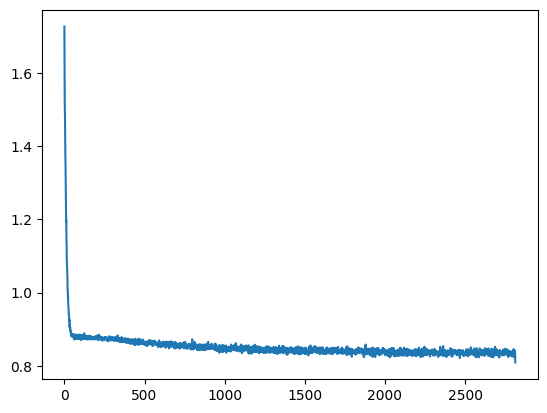

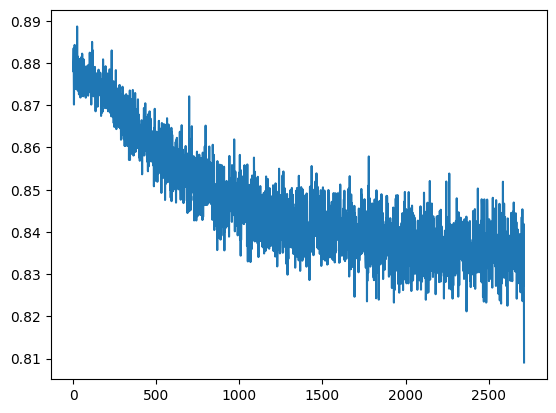

In [7]:
plt.plot(losses)
plt.show()
plt.plot(losses[100:])

torch.Size([64, 1, 64, 64])


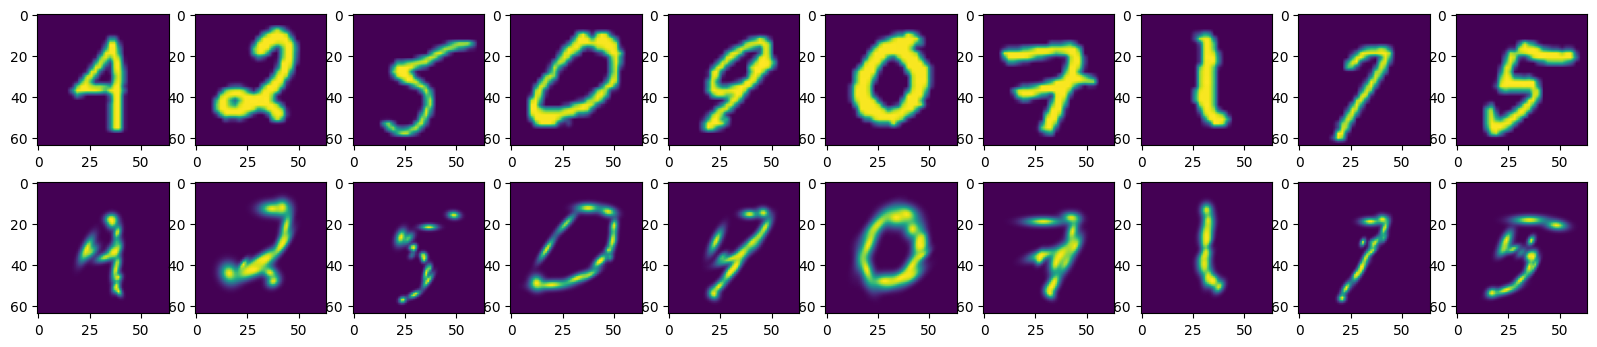

In [10]:
images = next(iter(trainloader))[0]
print(images.shape)

images = images.to(device)

# predict gaussians
rasterized_pred = model(images)


# plt.imshow(rasterized_pred[1].cpu().detach().numpy().squeeze())
# plt.show()
# plt.imshow(images[1].cpu().detach().numpy().squeeze())
# plt.show()

# create a plot comparing the original image to the rasterized image
fig, axs = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    axs[0, i].imshow(images[i].cpu().detach().numpy().squeeze())
    axs[1, i].imshow(rasterized_pred[i].cpu().detach().numpy().squeeze())
plt.show()

In [9]:
# compute loss
F.mse_loss(rasterized_pred, images)

tensor(0.8322, device='cuda:0', grad_fn=<MseLossBackward0>)